In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/patator.csv')

In [3]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [4]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [7]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [11]:
selected_features_indices = selector.get_support(indices=True)


In [12]:
selected_feature_names = X.columns[selected_features_indices]


In [13]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Fwd PSH Flags', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Average Packet Size', 'Avg Bwd Segment Size',
       'Init_Win_bytes_forward', 'act_data_pkt_fwd'],
      dtype='object')


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Predictions
y_pred = rf_model.predict(X_test_selected)

In [16]:
# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86310
           1       1.00      1.00      1.00      1587
           2       1.00      1.00      1.00      1232

    accuracy                           1.00     89129
   macro avg       1.00      1.00      1.00     89129
weighted avg       1.00      1.00      1.00     89129

Confusion Matrix:
[[86310     0     0]
 [    0  1587     0]
 [    1     0  1231]]


In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_selected), multi_class='ovr')


In [18]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9999887803071952
Precision: 0.9999887804371865
F1 Score: 0.9999887780620456
ROC AUC Score: 0.9999999911036278


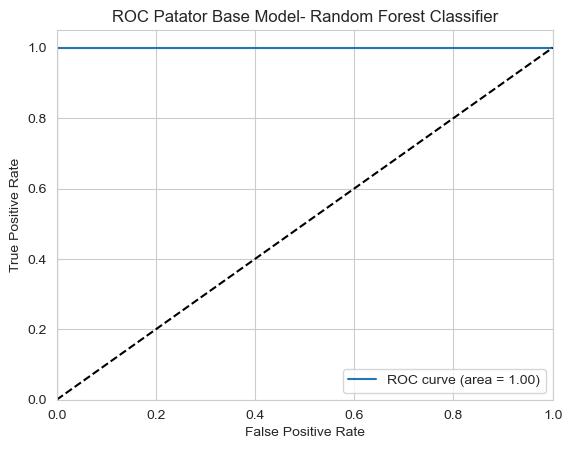

In [28]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test_selected)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Patator Base Model- Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[86310     0     0]
 [    0  1587     0]
 [    1     0  1231]]


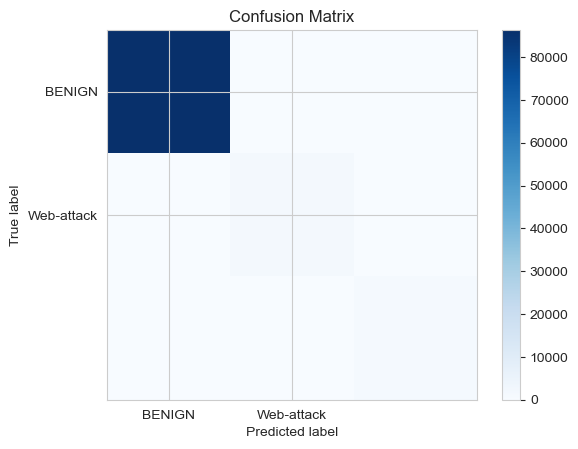

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['BENIGN', 'Web-attack'])
plt.yticks([0, 1], ['BENIGN', 'Web-attack'])
plt.show()

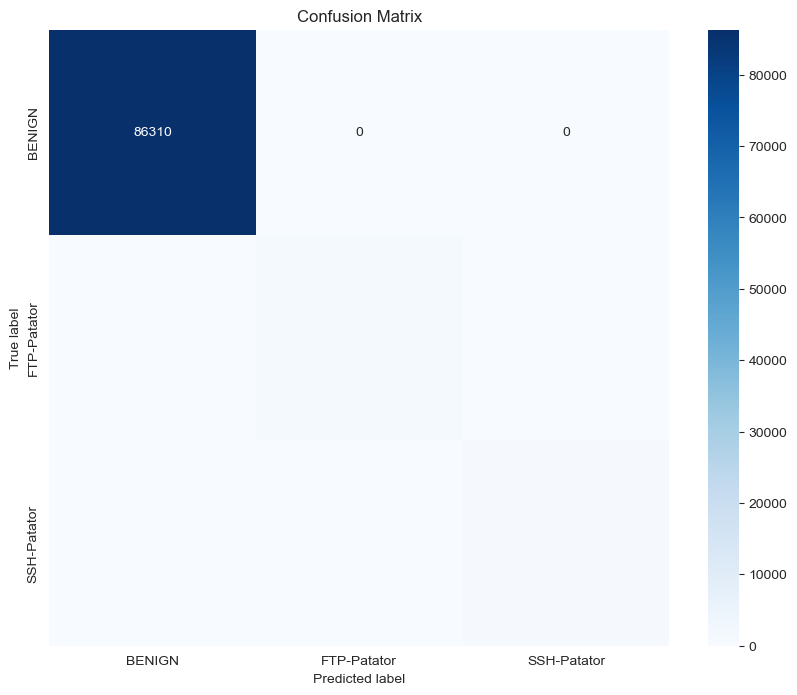

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
labels = label_encoder.classes_
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

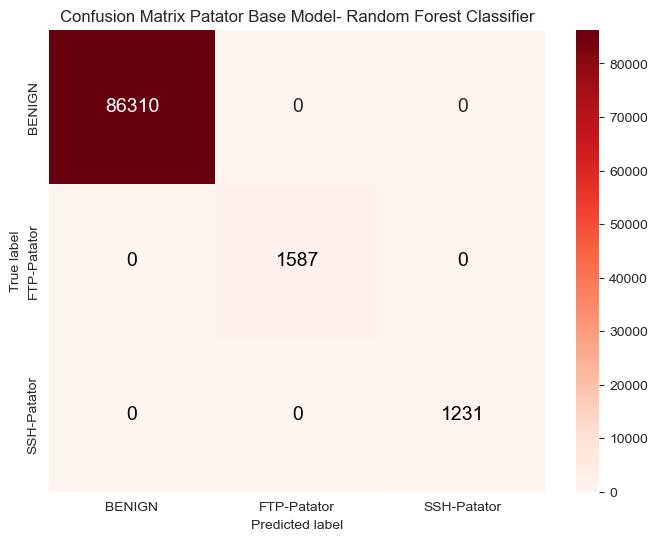

In [22]:
1# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 14}, 
            xticklabels=labels, yticklabels=labels)

# Manually annotate specific cells
plt.text(1.5, 1.5, '1587', fontsize=14, color='black', ha='center', va='center')
plt.text(2.5, 2.5, '1231', fontsize=14, color='black', ha='center', va='center')
plt.text(1.5, 2.5, '0', fontsize=14, color='black', ha='center', va='center')
plt.text(2.5, 1.5, '0', fontsize=14, color='black', ha='center', va='center')
plt.text(0.5, 1.5, '0', fontsize=14, color='black', ha='center', va='center')
plt.text(0.5, 2.5, '0', fontsize=14, color='black', ha='center', va='center')

plt.title('Confusion Matrix Patator Base Model- Random Forest Classifier')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Confusion Matrix:
[[86310     0     0]
 [    0  1587     0]
 [    1     0  1231]]


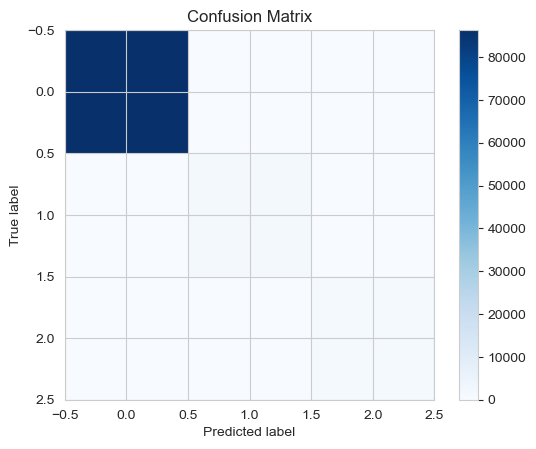

In [23]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

In [24]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 0
False Negatives: 0


In [25]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 89129


In [26]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 0.00%


In [27]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, 'rf_model_patator.pkl')


['rf_model_patator.pkl']